In [77]:
#dependencies (numpy, matplotlib, and keras)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

norm.ppf(np.linspace(0.05, 0.95, 10))

In [41]:
#hyperparameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

#encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

print(z_mean)
print(z_log_var)

Tensor("dense_7/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_8/BiasAdd:0", shape=(100, 2), dtype=float32)


In [42]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
    #return z_mean + z_log_var * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# keras.layers.core.Lambda(function, output_shape=None, mask=None, arguments=None)

#latent hidden state
print(z)

Tensor("lambda_2/add:0", shape=(100, 2), dtype=float32)


In [43]:
#decoder
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

print(x_decoded_mean)

Tensor("dense_10/Sigmoid:0", shape=(100, 784), dtype=float32)


In [44]:
#loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [45]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s - loss: 189.4117 - val_loss: 171.5691
Epoch 2/5
60000/60000 [==============================] - 11s - loss: 170.0024 - val_loss: 168.1498
Epoch 3/5
60000/60000 [==============================] - 11s - loss: 166.9565 - val_loss: 166.9204
Epoch 4/5
60000/60000 [==============================] - 11s - loss: 165.0250 - val_loss: 164.6580
Epoch 5/5
60000/60000 [==============================] - 11s - loss: 163.7335 - val_loss: 163.1787


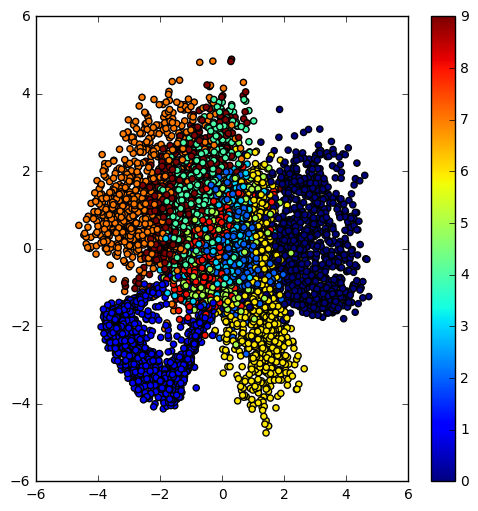

In [46]:
#plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

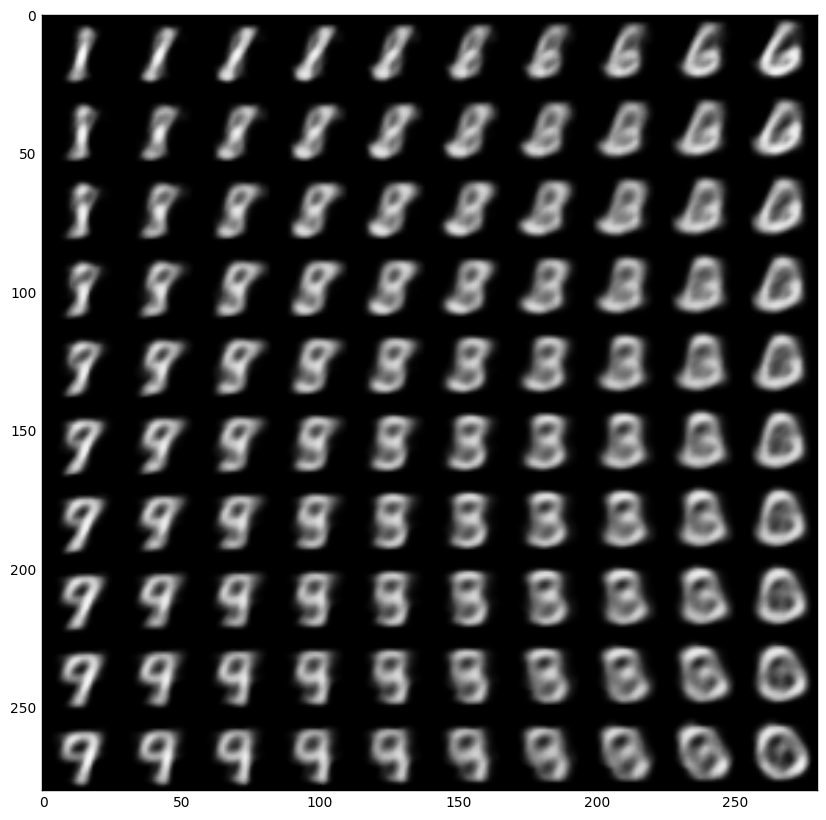

In [47]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
#array([-1.64485363, -1.03643339, -0.67448975, -0.38532047, -0.12566135,
        #0.12566135,  0.38532047,  0.67448975,  1.03643339,  1.64485363])
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

img = vae.predict(x_test1[0])
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
plt.show()

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
#in_imgs = mnist.test.images[:10]
in_imgs = x_test[:10]
#reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})
recoustructed = vae.predict(in_imgs).reshape(28,28)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

ValueError: Cannot feed value of shape (10, 784) for Tensor 'input_4:0', which has shape '(100, 784)'

In [49]:
x_test1 = x_test

x_test1[0]

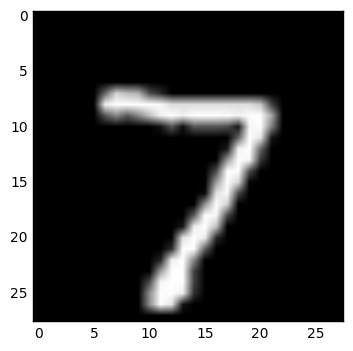

In [56]:
img = x_test1[0]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
plt.show()

x_decoded[0].reshape(28, 28)